# Predicting single-cell response to unseen  combinatorial CRISPR perturbations

In this tutorial, we will train and evaluate a CPA model on the [Norman 2019](https://www.google.com/search?q=norman+genetic+manifold&oq=norman+genetic+manifold&gs_lcrp=EgZjaHJvbWUyBggAEEUYOdIBCDMyMThqMGo3qAIAsAIA&sourceid=chrome&ie=UTF-8) dataset. See the last [Figure 5](https://www.embopress.org/doi/full/10.15252/msb.202211517) in the CPA paper. 

The goal is to predict gene expression response to perturbation responses of `X+Y` when you have seen single cells from `X` and `Y`. You can extend this model to predict 
`X+Y` when either `X`, `Y`, or both are unseen. In this scenario, you need to use external embedding for your favourite gene representations (see an example [here](https://cpa-tools.readthedocs.io/en/latest/tutorials/combosciplex_Rdkit_embeddings.html#))

The following steps are going to be covered:
1. Setting up environment
2. Loading the dataset
3. Preprocessing the dataset
4. Creating a CPA model
5. Training the model
6. Latent space visualisation
7. Prediction evaluation across different perturbations

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "latest"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install cpa-tools
    !pip install scanpy
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install git+https://github.com/theislab/cpa
    !pip install scanpy

In [2]:
import os
os.chdir('/home/mohsen/projects/cpa/')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import cpa
import scanpy as sc

Global seed set to 0


In [4]:
sc.settings.set_figure_params(dpi=100)

In [5]:
data_path = '/data/mohsen/scPert/scPerturb/Norman2019_normalized_hvg.h5ad'

## Loading dataset

The preprocessed Norman et. al 2019 dataset with `h5ad` extension used for saving/loading anndata objects is publicly available in the [Google Drive](https://drive.google.com/drive/folders/1pxT0fvXtqBBtdv1CCPVwJaMLHe9XpMHo?usp=sharing) and can be loaded using the `sc.read` function with the `backup_url` argument.

In [6]:
try:
    adata = sc.read(data_path)
except:
    import gdown
    gdown.download('https://drive.google.com/uc?export=download&id=109G9MmL-8-uh7OSjnENeZ5vFbo62kI7j')
    data_path = 'Norman2019_normalized_hvg.h5ad'
    adata = sc.read(data_path)

adata

AnnData object with n_obs × n_vars = 111122 × 5044
    obs: 'guide_id', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'perturbation', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'n_counts', 'condition', 'pert_type', 'cell_type', 'source', 'condition_ID', 'control', 'dose_value', 'pathway', 'cov_cond', 'pert', 'split_hardest', 'split_1', 'split_2', 'split_3', 'split_4', 'split_5', 'split_6', 'cond_harm'
    var: 'ensemble_id', 'ncounts', 'ncells', 'symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'gene_embedding_path', 'hvg', 'log1p', 'neighbors', 'rank_genes_groups_cov', 'source_colors', 'split_1_colors', 'split_2_colors', 'split_3_colors', 'split_4_colors', 'split_5_colors', 'split_hardest_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'd

Next, we just replace `adata.X` with raw counts to be able to train CPA with Negative Binomial (aka NB) loss.

In [7]:
adata.X = adata.layers['counts'].copy()

## Pre-processing Dataset
Preprocessing is the first step required for training a model. Just like scvi-tools models, you can call `cpa.CPA.setup_anndata` to preprocess your data. This function will accept the following arguments:
- `adata`: AnnData object containing the data to be preprocessed
- `perturbation_key`: The key in `adata.obs` that contains the perturbation information
- `control_group`: The name of the control group in `perturbation_key`
- `batch_key`: The key in `adata.obs` that contains the batch information
- `dosage_key`: The key in `adata.obs` that contains the dosage information
- `categorical_covariate_keys`: A list of keys in `adata.obs` that contain categorical covariates
- `is_count_data`: Whether the `adata.X` is count data or not
- `deg_uns_key`: The key in `adata.uns` that contains the differential expression results
- `deg_uns_cat_key`: The key in `adata.obs` that contains the category information of each cell which can be used as to access differential expression results in `adata.uns[deg_uns_key]`. For example, if `deg_uns_key` is `rank_genes_groups_cov` and `deg_uns_cat_key` is `cov_cond`, then `adata.uns[deg_uns_key][cov_cond]` will contain the differential expression results for each category in `cov_cond`.
- `max_comb_len`: The maximum number of perturbations that are applied to each cell. For example, if `max_comb_len` is 2, then the model will be trained to predict the effect of single perturbations and the effect of double perturbations.

In [8]:
cpa.CPA.setup_anndata(adata, 
                      perturbation_key='cond_harm',
                      control_group='ctrl',
                      dosage_key='dose_value',
                      categorical_covariate_keys=['cell_type'],
                      is_count_data=True,
                      deg_uns_key='rank_genes_groups_cov',
                      deg_uns_cat_key='cov_cond',
                      max_comb_len=2,
                     )

100%|██████████| 235/235 [00:00<00:00, 1089.26it/s]
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [9]:
model_params = {
    "n_latent": 32,
    "recon_loss": "nb",
    "doser_type": "linear",
    "n_hidden_encoder": 256,
    "n_layers_encoder": 4,
    "n_hidden_decoder": 256,
    "n_layers_decoder": 2,
    "use_batch_norm_encoder": True,
    "use_layer_norm_encoder": False,
    "use_batch_norm_decoder": False,
    "use_layer_norm_decoder": False,
    "dropout_rate_encoder": 0.2,
    "dropout_rate_decoder": 0.0,
    "variational": False,
    "seed": 8206,
}

trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 10,
    "n_epochs_pretrain_ae": 10,
    "mixup_alpha": 0.1,
    "lr": 0.0001,
    "wd": 3.2170178270865573e-06,
    "adv_steps": 3,
    "reg_adv": 10.0,
    "pen_adv": 20.0,
    "adv_lr": 0.0001,
    "adv_wd": 7.051355554517135e-06,
    "n_layers_adv": 2,
    "n_hidden_adv": 128,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "step_size_lr": 25,
    "do_clip_grad": False,
    "adv_loss": "cce",
    "gradient_clip_value": 5.0,
}

Dataset split: We leave DUSP9+ETS2 and CNN1+CBL out of training dataset.

In [12]:
import numpy as np

In [15]:
adata.obs['split'] = np.random.choice(['train', 'valid'], size=adata.n_obs, p=[0.85, 0.15])
adata.obs.loc[adata.obs['cond_harm'].isin(['DUSP9+ETS2', 'CBL+CNN1']), 'split'] = 'ood'

In [16]:
adata.obs['split'].value_counts()

split
train    93470
valid    16517
ood       1135
Name: count, dtype: int64

## CPA Model

You can create a CPA model by creating an object from `cpa.CPA` class. The constructor of this class takes the following arguments:
**Data related parameters:** 
- `adata`: AnnData object containing train/valid/test data
- `split_key`: The key in `adata.obs` that contains the split information
- `train_split`: The value in `split_key` that corresponds to the training data
- `valid_split`: The value in `split_key` that corresponds to the validation data
- `test_split`: The value in `split_key` that corresponds to the test data
**Model architecture parameters:**
- `n_latent`: Number of latent dimensions
- `recon_loss`: Reconstruction loss function. Currently, Supported losses are `nb`, `zinb`, and `gauss`.
- `n_hidden_encoder`: Number of hidden units in the encoder
- `n_layers_encoder`: Number of layers in the encoder
- `n_hidden_decoder`: Number of hidden units in the decoder
- `n_layers_decoder`: Number of layers in the decoder
- `use_batch_norm_encoder`: Whether to use batch normalization in the encoder
- `use_layer_norm_encoder`: Whether to use layer normalization in the encoder
- `use_batch_norm_decoder`: Whether to use batch normalization in the decoder
- `use_layer_norm_decoder`: Whether to use layer normalization in the decoder
- `dropout_rate_encoder`: Dropout rate in the encoder
- `dropout_rate_decoder`: Dropout rate in the decoder
- `variational`: Whether to use variational inference. NOTE: False is highly recommended.
- `seed`: Random seed

In [17]:
model = cpa.CPA(adata=adata, 
                split_key='split',
                train_split='train',
                valid_split='valid',
                test_split='ood',
                **model_params,
               )

Global seed set to 8206


## Training CPA

In order to train your CPA model, you need to use `train` function of your `model`. This function accepts the following parameters:
- `max_epochs`: Maximum number of epochs to train the model. CPA generally converges after high number of epochs, so you can set this to a high value.
- `use_gpu`: If you have a GPU, you can set this to `True` to speed up the training process.
- `batch_size`: Batch size for training. You can set this to a high value (e.g. 512, 1024, 2048) if you have a GPU. 
- `plan_kwargs`: dictionary of parameters passed the CPA's `TrainingPlan`. You can set the following parameters:
    * `n_epochs_adv_warmup`: Number of epochs to linearly increase the weight of adversarial loss. 
    * `n_epochs_mixup_warmup`: Number of epochs to linearly increase the weight of mixup loss.
    * `n_epochs_pretrain_ae`: Number of epochs to pretrain the autoencoder.
    * `lr`: Learning rate for training autoencoder.
    * `wd`: Weight decay for training autoencoder.
    * `adv_lr`: Learning rate for training adversary.
    * `adv_wd`: Weight decay for training adversary.
    * `adv_steps`: Number of steps to train adversary for each step of autoencoder.
    * `reg_adv`: Maximum Weight of adversarial loss.
    * `pen_adv`: Penalty weight of adversarial loss.
    * `n_layers_adv`: Number of layers in adversary.
    * `n_hidden_adv`: Number of hidden units in adversary.
    * `use_batch_norm_adv`: Whether to use batch normalization in adversary.
    * `use_layer_norm_adv`: Whether to use layer normalization in adversary.
    * `dropout_rate_adv`: Dropout rate in adversary.
    * `step_size_lr`: Step size for learning rate scheduler.
    * `do_clip_grad`: Whether to clip gradients by norm.
    * `clip_grad_value`: Maximum value of gradient norm.
    * `adv_loss`: Type of adversarial loss. Can be either `cce` for Cross Entropy loss or `focal` for Focal loss.
    * `n_epochs_verbose`: Number of epochs to print latent information disentanglement evaluation.
- `early_stopping_patience`: Number of epochs to wait before stopping training if validation metric does not improve.
- `check_val_every_n_epoch`: Number of epochs to wait before running validation.
- `save_path`: Path to save the best model after training.



In [18]:
model.train(max_epochs=2000,
            use_gpu=True, 
            batch_size=2048,
            plan_kwargs=trainer_params,
            early_stopping_patience=5,
            check_val_every_n_epoch=5,
            save_path='/home/mohsen/projects/cpa/lightning_logs/Norman2019/',
           )

100%|██████████| 235/235 [00:01<00:00, 131.59it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5/2000:   0%|          | 4/2000 [02:38<22:27:50, 40.52s/it, v_num=1, recon=1.34e+3, r2_mean=0.902, adv_loss=5.58, acc_pert=0.00407]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/2000:   0%|          | 9/2000 [06:03<21:52:10, 39.54s/it, v_num=1, recon=1.3e+3, r2_mean=0.931, adv_loss=5.56, acc_pert=0.00451, val_recon=1.38e+3, disnt_basal=0.00858, disnt_after=0.182, val_r2_mean=0.876, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.010961215038908775
disnt_after = 0.19502456758338688
val_r2_mean = 0.9154374487918793
val_r2_var = 0.20423474753644089
Epoch 15/2000:   1%|          | 14/2000 [09:22<21:32:39, 39.05s/it, v_num=1, recon=1.29e+3, r2_mean=0.947, adv_loss=5.53, acc_pert=0.00529, val_recon=1.34e+3, disnt_basal=0.011, disnt_after=0.195, val_r2_mean=0.915, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/2000:   1%|          | 19/2000 [12:38<20:58:33, 38.12s/it, v_num=1, recon=1.29e+3, r2_mean=0.95, adv_loss=5.51, acc_pert=0.00615, val_recon=1.3e+3, disnt_basal=0.0112, disnt_after=0.162, val_r2_mean=0.942, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.011444479232220443
disnt_after = 0.1581131598607452
val_r2_mean = 0.9434537314610315
val_r2_var = 0.27399132318766495
Epoch 25/2000:   1%|          | 24/2000 [15:58<21:18:20, 38.82s/it, v_num=1, recon=1.28e+3, r2_mean=0.953, adv_loss=5.49, acc_pert=0.00668, val_recon=1.29e+3, disnt_basal=0.0114, disnt_after=0.158, val_r2_mean=0.943, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/2000:   1%|▏         | 29/2000 [19:25<22:14:11, 40.61s/it, v_num=1, recon=1.28e+3, r2_mean=0.955, adv_loss=5.47, acc_pert=0.00676, val_recon=1.29e+3, disnt_basal=0.0113, disnt_after=0.156, val_r2_mean=0.949, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.011127572799464512
disnt_after = 0.1575390785770161
val_r2_mean = 0.9503723221781565
val_r2_var = 0.2894487031155922
Epoch 35/2000:   2%|▏         | 34/2000 [22:47<21:28:12, 39.31s/it, v_num=1, recon=1.28e+3, r2_mean=0.956, adv_loss=5.45, acc_pert=0.00778, val_recon=1.28e+3, disnt_basal=0.0111, disnt_after=0.158, val_r2_mean=0.95, val_KL=nan] 


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/2000:   2%|▏         | 39/2000 [26:04<21:00:33, 38.57s/it, v_num=1, recon=1.28e+3, r2_mean=0.957, adv_loss=5.43, acc_pert=0.00809, val_recon=1.28e+3, disnt_basal=0.0114, disnt_after=0.159, val_r2_mean=0.951, val_KL=nan]
disnt_basal = 0.011515587029607442
disnt_after = 0.15766061413614593
val_r2_mean = 0.9522184643801245
val_r2_var = 0.29852997620728705
Epoch 45/2000:   2%|▏         | 44/2000 [29:27<21:34:32, 39.71s/it, v_num=1, recon=1.28e+3, r2_mean=0.959, adv_loss=5.41, acc_pert=0.0089, val_recon=1.28e+3, disnt_basal=0.0115, disnt_after=0.158, val_r2_mean=0.952, val_KL=nan] 


Epoch 00044: cpa_metric reached. Module best state updated.


Epoch 50/2000:   2%|▏         | 49/2000 [32:53<21:51:56, 40.35s/it, v_num=1, recon=1.27e+3, r2_mean=0.959, adv_loss=5.39, acc_pert=0.00971, val_recon=1.28e+3, disnt_basal=0.0112, disnt_after=0.158, val_r2_mean=0.953, val_KL=nan]


Epoch 00049: cpa_metric reached. Module best state updated.



disnt_basal = 0.010984826151774645
disnt_after = 0.15677847455688607
val_r2_mean = 0.9541469256027013
val_r2_var = 0.30660884410367206
Epoch 55/2000:   3%|▎         | 54/2000 [36:13<21:11:43, 39.21s/it, v_num=1, recon=1.27e+3, r2_mean=0.96, adv_loss=5.38, acc_pert=0.0104, val_recon=1.28e+3, disnt_basal=0.011, disnt_after=0.157, val_r2_mean=0.954, val_KL=nan]   


Epoch 00054: cpa_metric reached. Module best state updated.


Epoch 60/2000:   3%|▎         | 59/2000 [39:35<21:11:46, 39.31s/it, v_num=1, recon=1.27e+3, r2_mean=0.96, adv_loss=5.36, acc_pert=0.0114, val_recon=1.27e+3, disnt_basal=0.011, disnt_after=0.158, val_r2_mean=0.952, val_KL=nan]


Epoch 00059: cpa_metric reached. Module best state updated.



disnt_basal = 0.011124381985943432
disnt_after = 0.15875454296061095
val_r2_mean = 0.9546145424583039
val_r2_var = 0.31326003476979347
Epoch 65/2000:   3%|▎         | 64/2000 [42:54<20:48:30, 38.69s/it, v_num=1, recon=1.27e+3, r2_mean=0.961, adv_loss=5.34, acc_pert=0.0123, val_recon=1.27e+3, disnt_basal=0.0111, disnt_after=0.159, val_r2_mean=0.955, val_KL=nan]


Epoch 00064: cpa_metric reached. Module best state updated.


Epoch 70/2000:   3%|▎         | 69/2000 [46:12<20:35:20, 38.38s/it, v_num=1, recon=1.27e+3, r2_mean=0.961, adv_loss=5.33, acc_pert=0.0126, val_recon=1.27e+3, disnt_basal=0.0112, disnt_after=0.16, val_r2_mean=0.956, val_KL=nan] 
disnt_basal = 0.010895616777928874
disnt_after = 0.15808631004277954
val_r2_mean = 0.957815544967096
val_r2_var = 0.3212294877744317
Epoch 75/2000:   4%|▎         | 74/2000 [49:31<20:33:19, 38.42s/it, v_num=1, recon=1.26e+3, r2_mean=0.962, adv_loss=5.31, acc_pert=0.0127, val_recon=1.27e+3, disnt_basal=0.0109, disnt_after=0.158, val_r2_mean=0.958, val_KL=nan]


Epoch 00074: cpa_metric reached. Module best state updated.


Epoch 80/2000:   4%|▍         | 79/2000 [52:53<20:57:47, 39.29s/it, v_num=1, recon=1.26e+3, r2_mean=0.963, adv_loss=5.29, acc_pert=0.0136, val_recon=1.27e+3, disnt_basal=0.011, disnt_after=0.153, val_r2_mean=0.957, val_KL=nan] 


Epoch 00079: cpa_metric reached. Module best state updated.



disnt_basal = 0.01086391288036882
disnt_after = 0.15471027731083284
val_r2_mean = 0.9599525975767264
val_r2_var = 0.33342668163072686
Epoch 90/2000:   4%|▍         | 89/2000 [58:01<15:40:06, 29.52s/it, v_num=1, recon=1.26e+3, r2_mean=0.964, adv_loss=5.26, acc_pert=0.0141, val_recon=1.26e+3, disnt_basal=0.011, disnt_after=0.151, val_r2_mean=0.959, val_KL=nan]
disnt_basal = 0.010541276699388398
disnt_after = 0.145813479944288
val_r2_mean = 0.9588718352672085
val_r2_var = 0.34985344329655926
Epoch 100/2000:   5%|▍         | 99/2000 [1:03:03<15:25:17, 29.20s/it, v_num=1, recon=1.26e+3, r2_mean=0.964, adv_loss=5.23, acc_pert=0.0161, val_recon=1.26e+3, disnt_basal=0.0105, disnt_after=0.147, val_r2_mean=0.959, val_KL=nan]
disnt_basal = 0.010723691689400202
disnt_after = 0.14638131001386656
val_r2_mean = 0.960419804421332
val_r2_var = 0.34471244804718837
Epoch 105/2000:   5%|▌         | 105/2000 [1:06:16<19:56:11, 37.87s/it, v_num=1, recon=1.26e+3, r2_mean=0.965, adv_loss=5.22, acc_pert=0.016

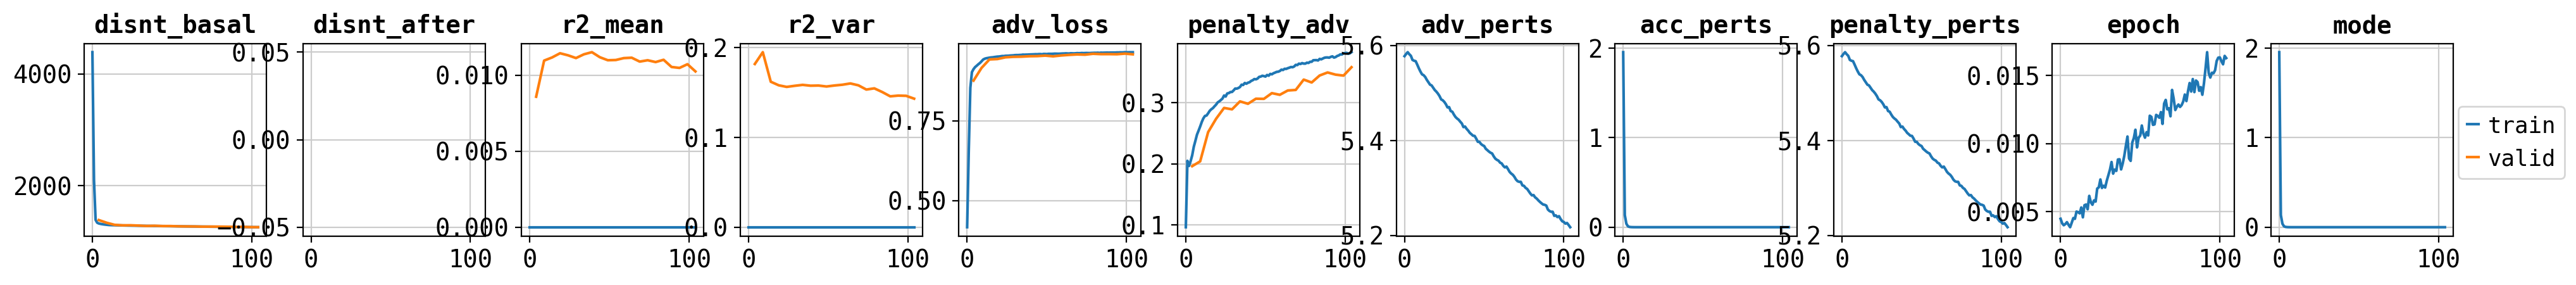

In [19]:
cpa.pl.plot_history(model)

## Restore best model

In case you have already saved your pretrained model, you can restore it using the following code. The `cpa.CPA.load` function accepts the following arguments:
- `dir_path`: path to the directory where the model is saved
- `adata`: anndata object
- `use_gpu`: whether to use GPU or not


In [20]:
# model = cpa.CPA.load(dir_path='/home/mohsen/projects/cpa/lightning_logs/Norman2019/',
#                      adata=adata,
#                      use_gpu=True)

## Latent Space Visualization

latent vectors of all cells can be computed with `get_latent_representation` function. This function produces a python dictionary with the following keys:
- `latent_basal`: latent vectors of all cells in basal state of autoencoder
- `latent_after`: final latent vectors which can be used for decoding
- `latent_corrected`: batch-corrected latents if batch_key was provided

In [21]:
latent_outputs = model.get_latent_representation(adata, batch_size=2048)

100%|██████████| 55/55 [00:19<00:00,  2.82it/s]


In [22]:
latent_outputs.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

In [23]:
sc.pp.neighbors(latent_outputs['latent_basal'])
sc.tl.umap(latent_outputs['latent_basal'])

In [43]:
groups = list(np.unique(adata[adata.obs['split'] == 'ood'].obs['cond_harm'].values))
len(groups)

2

As observed below, the basal representation should be free of the variation(s) of the `cond_harm`

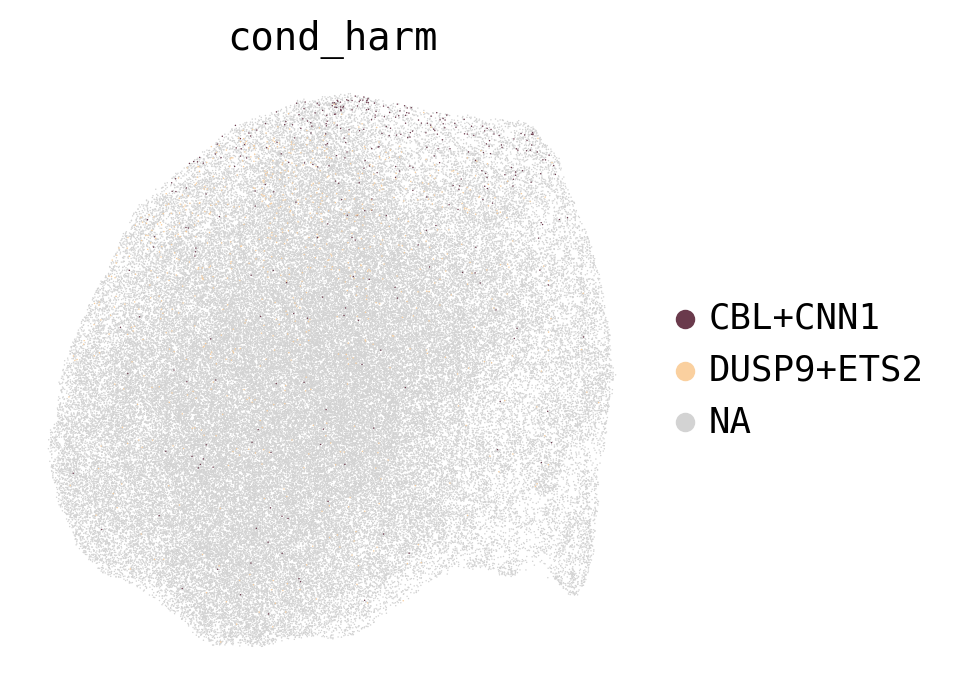

In [44]:
sc.pl.umap(latent_outputs['latent_basal'], 
           color='cond_harm', 
           groups=groups,
           palette=sc.pl.palettes.godsnot_102,
           frameon=False)

We can further color them by the gene programs that each perturbation will induce

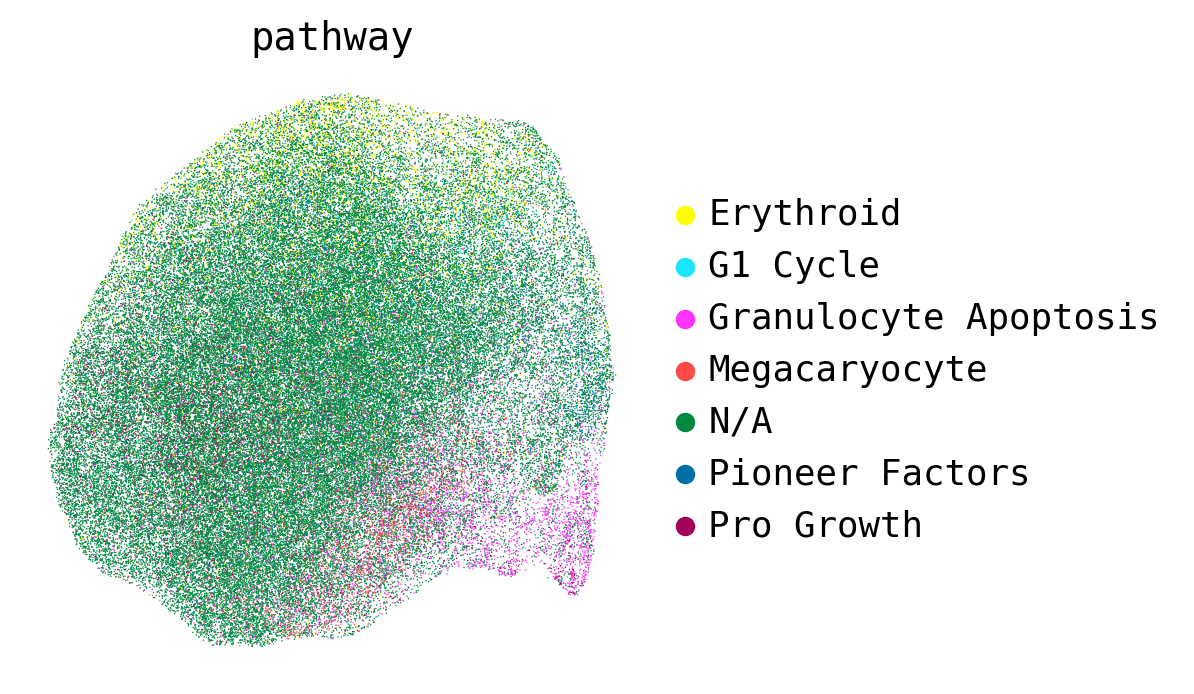

In [26]:
sc.pl.umap(latent_outputs['latent_basal'], 
           color='pathway', 
           palette=sc.pl.palettes.godsnot_102,
           frameon=False)

In [27]:
sc.pp.neighbors(latent_outputs['latent_after'])
sc.tl.umap(latent_outputs['latent_after'])

Here, you can visualise that when gene embeddings are added to the basal representation, the cells treated with different drugs will be separated.

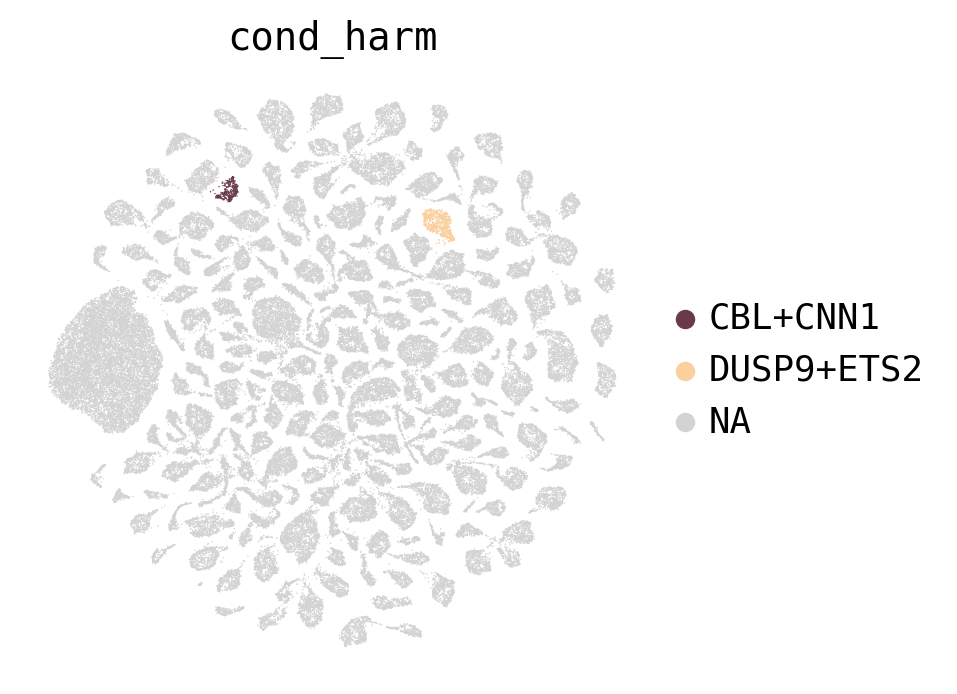

In [45]:
sc.pl.umap(latent_outputs['latent_after'], 
           color='cond_harm', 
           groups=groups,
           palette=sc.pl.palettes.godsnot_102,
           frameon=False)

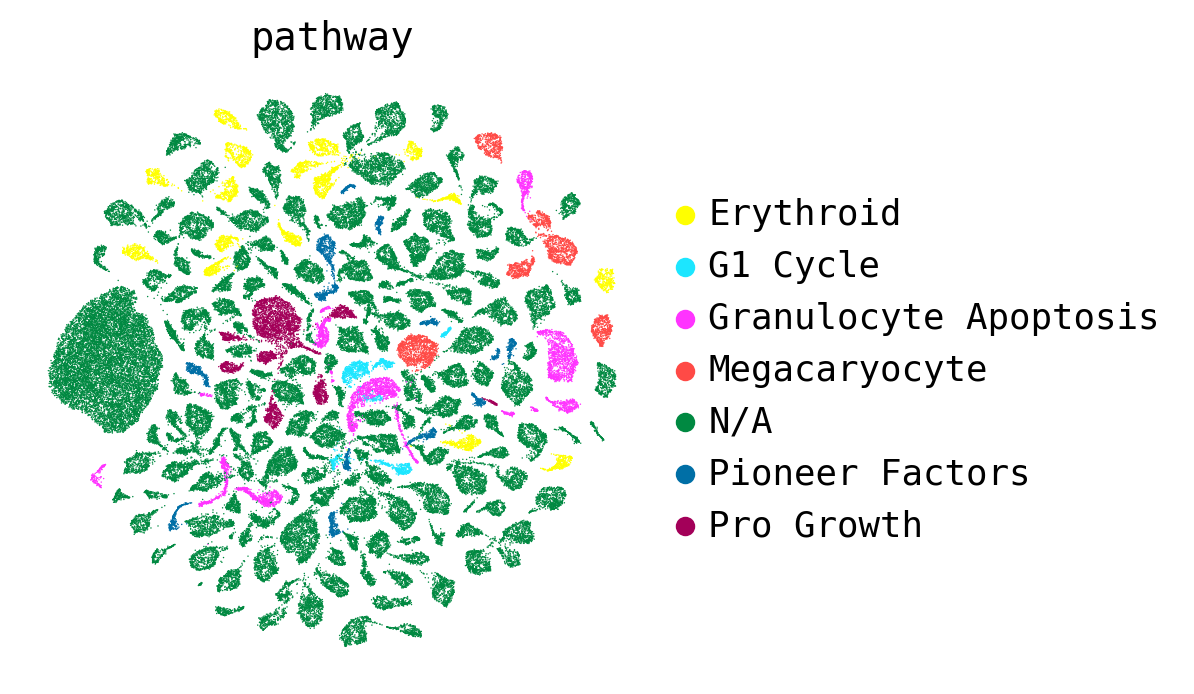

In [29]:
sc.pl.umap(latent_outputs['latent_after'], 
           color='pathway', 
           palette=sc.pl.palettes.godsnot_102,
           frameon=False)

## Evaluation 

To evaluate the model's prediction performance, we can use `model.predict()` function. $R^2$ score for each genetic interaction (GI) is computed over mean statistics of the top 50, 20, and 10 DEGs (including all genes). CPA transfers the context from control to GI-perturbed for K562 cells. Next, we will evaluate the model's prediction performance on the whole dataset, including OOD (test) cells. The model will report metrics on how well we have
captured the variation in top `n` differentially expressed genes when compared to control cells
(`CTRL`)  for each condition. The metrics calculate the mean accuracy (`r2_mean_deg`) and mean log-fold-change accuracy (`r2_mean_lfc_deg`).  The `R2` is the `sklearn.metrics.r2_score` from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html).

NOTE: To perform counter-factual prediction, we first need to set `adata.X` to sampled control cells. Then, we can use `model.predict()` function to predict the effect of perturbations on these cells. 

In [31]:
adata.layers['X_true'] = adata.X.copy()

In [32]:
ctrl_adata = adata[adata.obs['cond_harm'] == 'ctrl'].copy()

adata.X = ctrl_adata.X[np.random.choice(ctrl_adata.n_obs, size=adata.n_obs, replace=True), :]

In [33]:
model.predict(adata, batch_size=2048)

100%|██████████| 55/55 [00:23<00:00,  2.36it/s]


In [35]:
adata.layers['CPA_pred'] = adata.obsm['CPA_pred'].copy()

In [36]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.normalize_total(adata, target_sum=1e4, layer='CPA_pred')
sc.pp.log1p(adata, layer='CPA_pred')

In [37]:
adata.X.max(), adata.layers['CPA_pred'].max()

(8.682708, 7.485055)

In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from collections import defaultdict
from tqdm import tqdm

n_top_degs = [10, 20, 50, None] # None means all genes

results = defaultdict(list)
ctrl_adata = adata[adata.obs['cond_harm'] == 'ctrl'].copy()
for condition in tqdm(adata.obs['cond_harm'].unique()):
    if condition != 'ctrl':
        cond_adata = adata[adata.obs['cond_harm'] == condition].copy()

        deg_cat = f'K562_{condition}'
        deg_list = adata.uns['rank_genes_groups_cov'][deg_cat]
        
        x_true = cond_adata.layers['counts'].toarray()
        x_pred = cond_adata.obsm['CPA_pred']
        x_ctrl = ctrl_adata.layers['counts'].toarray()

        for n_top_deg in n_top_degs:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'
                
            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]
            x_ctrl_deg = x_ctrl[:, degs]
            
            r2_mean_deg = r2_score(x_true_deg.mean(0), x_pred_deg.mean(0))

            r2_mean_lfc_deg = r2_score(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))
            
            results['condition'].append(condition)
            results['n_top_deg'].append(n_top_deg)
            results['r2_mean_deg'].append(r2_mean_deg)
            results['r2_mean_lfc_deg'].append(r2_mean_lfc_deg)

df = pd.DataFrame(results)

100%|██████████| 235/235 [03:58<00:00,  1.01s/it]


In [54]:
df[df['condition'].isin(['DUSP9+ETS2', 'CBL+CNN1'])]

,condition,n_top_deg,r2_mean_deg,r2_mean_lfc_deg
128,DUSP9+ETS2,10,0.952312,0.491988
129,DUSP9+ETS2,20,0.949986,0.792572
130,DUSP9+ETS2,50,0.965770,0.802342
131,DUSP9+ETS2,all,0.973744,0.653967
588,CBL+CNN1,10,0.840003,0.810792
589,CBL+CNN1,20,0.883622,0.831620
590,CBL+CNN1,50,0.951045,0.830260
591,CBL+CNN1,all,0.972246,0.827092
